# Load Data

In [1]:
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Pillow
from PIL import Image
# Torch
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
from torchvision import transforms
# from torchsummary import summary
# Misc
import time
from datetime import datetime
# preprocessing 
import sys
import av
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

In [2]:
data_dir = "dataset"
test_dir = f'../../{data_dir}/test'

In [3]:
# All labels
filtered_data = "data"
test_label_df = pd.read_csv(f'../../{filtered_data}/test.csv', header=None)

# convert all into hashmap - key = u_vid_name , value = label
test_label = {f"../../{test_dir}/{k[0]}": k[1] for k in test_label_df.values.tolist()}

In [4]:
# Total label + turkish to english translation
total_label = pd.read_csv(f'../../{filtered_data}/filtered_ClassId.csv')
u_len_label = len(total_label['ClassId'].unique())
print("total unique label:", u_len_label)

total unique label: 10


In [5]:
class_id_to_label = {k[0]: k[2] for k in total_label.values.tolist()}

In [6]:
print(class_id_to_label)

{0: 'champion', 1: 'glass', 2: 'wrong', 3: 'bad', 4: 'married', 5: 'potato', 6: 'congratulations', 7: 'child', 8: 'inform', 9: 'father'}


# Load video

In [7]:
def extract_frames(vid_path, frames_cap, transforms=None):
    """Extract and transform video frames

    Parameters:
    vid_path (str): path to video file
    frames_cap (int): number of frames to extract, evenly spaced
    transforms (torchvision.transforms, optional): transformations to apply to frame

    Returns:
    list of numpy.array: vid_arr

    """
    vid_arr = []
    with av.open(vid_path) as container:
        stream = container.streams.video[0]
        n_frames = stream.frames
        remainder = n_frames % frames_cap
        interval = n_frames // frames_cap
        take_frame_idx = 0
        for frame_no, frame in enumerate(container.decode(stream)):
            if frame_no == take_frame_idx:
                img = frame.to_image()
                if transforms:
                    img = transforms(img)
                vid_arr.append(np.array(img))
                if remainder > 0:
                    take_frame_idx += 1
                    remainder -= 1
                take_frame_idx += interval
    if len(vid_arr) < frames_cap:
        raise ValueError(f"video with path '{vid_path}' is too short, please make sure that video has >={frames_cap} frames")
    return vid_arr

In [8]:
transforms_compose = transforms.Compose([transforms.Resize(256), 
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.5], std=[0.5])])
vid_name = "signer34_sample4"
vid_color_path = f"{test_dir}/{vid_name}_color.mp4"
rgb_arr = extract_frames(vid_color_path, 30, transforms=transforms_compose)
vid_arr = np.array(rgb_arr)
print(vid_arr.shape)
vid_arr = torch.from_numpy(vid_arr).float()
vid_arr = vid_arr.unsqueeze(0)
# batch_size, timesteps, C, H, W = x.size()

(30, 3, 256, 256)


In [9]:
print(vid_arr.size())

torch.Size([1, 30, 3, 256, 256])


torch.Size([30, 3, 256, 256])


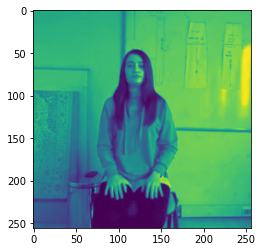

In [10]:
print(vid_arr[0].shape)
img_np_arr = vid_arr[0][0][0].numpy()
plt.imshow(img_np_arr)
plt.show()

# Load and test model

In [11]:
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [12]:
from models import CNN_LSTM
model = CNN_LSTM(10, 
                 latent_size=512, 
                 n_cnn_layers=6, 
                 n_rnn_layers=1, 
                 n_rnn_hidden_dim=512, 
                 cnn_bn=True, 
                 bidirectional=True, 
                 dropout_rate=0.8,
                 device="cpu",
                 attention=True)
checkpoint = torch.load("../../models/8-checkpoint.pt", map_location=torch.device("cpu"))
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

CNN_LSTM(
  (encoder): CNN_Encoder(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (layers): Sequential(
      (0): ConvBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
        (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
        (a_fn): ReLU()
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (1): ConvBlock(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
        (batchnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
        (batchnorm2): BatchNorm2d(128, 

In [13]:
output = model.forward(vid_arr)
output = output.argmax(1)
output = output.item()
print(output)

4


In [28]:
transforms_compose = transforms.Compose([transforms.Resize(256), 
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.5], std=[0.5])])
test_dir = f'../../{data_dir}/test'
def load_and_test_image(vid_name):
    vid_color_path = f"{test_dir}/{vid_name}_color.mp4"
    rgb_arr = extract_frames(vid_color_path, 30, transforms=transforms_compose)
    vid_arr = np.array(rgb_arr)
    vid_arr = vid_arr/255
    vid_arr = torch.from_numpy(vid_arr).float()
    vid_arr = vid_arr.unsqueeze(0)
    predict_id = model.forward(vid_arr)
    predict_id = predict_id.argmax(1).item()
    real_id = test_label[f"../../{test_dir}/{vid_name}"]
    return predict_id, class_id_to_label[predict_id], real_id, class_id_to_label[real_id]
    


In [31]:
df = pd.read_csv("../../data/test.csv", names=["video_name", "class_id"])
predict_ids = []
predict_labels = []
real_ids = []
real_labels = []
for index, row in df.iterrows():
    predict_id, predict_label, real_id, real_label = load_and_test_image(row['video_name'])
    predict_ids.append(predict_id)
    predict_labels.append(predict_label)
    real_ids.append(real_id)
    real_labels.append(real_label)

df['predict_id'] = predict_ids
df['predict_label'] = predict_labels
df['real_id'] = real_ids
df['real_label'] = real_labels
    
    # df["prediction"] = df.apply(lambda row : copy_data(source_dir, row['video_name'], save_dir), axis = 1)
# df[['prediction', 'label']] = df.apply(lambda row : load_and_test_image(row['video_name']), axis = 1)

0
2
8
4
7
8
0
6
9
9
7
1
8
2
1
3
6
0
5
4
6
3
5
1
3
4
2
7
9
5
5
3
4
3
9
1
3
6
8
6
4
0
9
9
7
0
4
8
0
5
1
5
2
8
2
7
1
7
2
6
4
8
2
5
1
3
7
5
0
2
0
0
1
4
9
7
8
7
1
9
5
9
2
3
4
8
3
5
3
4
8
7
0
1
7
3
0
6
1
8
2
5
2
6
9
4
9
5
3
6
8
4
2
2
3
0
1
6
9
2
6
8
7
5
3
0
7
8
9
4
7
0
5
4
1
2
7
9
7
2
9
8
5
4
1
8
1
0
7
5
9
8
6
0
2
3
0
5
1
3
4
6
6
3


In [32]:
df

,video_name,class_id,predict_id,predict_label,real_id,real_label
0,signer34_sample4,0,0,champion,0,champion
1,signer34_sample43,2,2,wrong,2,wrong
2,signer34_sample130,8,0,champion,8,inform
3,signer34_sample145,4,4,married,4,married
4,signer34_sample170,7,3,bad,7,child
...,...,...,...,...,...,...
159,signer30_sample575,3,6,congratulations,3,bad
160,signer30_sample576,4,5,potato,4,married
161,signer30_sample588,6,5,potato,6,congratulations
162,signer30_sample617,6,5,potato,6,congratulations


In [33]:
real_label = test_label[f"../../{test_dir}/{vid_name}"]
print(real_label)
# output = F.one_hot(output, num_classes=labels.shape[1])

0


In [34]:
output_label = class_id_to_label[output]
real_label = class_id_to_label[real_label]
print(f"Output label: {output_label}")
print(f"Real label: {real_label}")

Output label: married
Real label: champion
